In [1]:
import random
import sys
sys.path.append('src/')
sys.path.append('experiments/')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error
from sklearn.model_selection import train_test_split

from src.clause_generator import ClauseGenerator
from src.ilp_solver import ILPSolver
from src.ilp_problem import ILPProblem
from src.data_utils import DataUtils
from src.visualize import Visualize
from experiments.parameters import get_parameters
from experiments.eval_utils import get_dataset_with_noise, compute_auc, compute_mse, extract

In [2]:
### problem
problem = 'windy_lava'
# problem = 'delete'
#problem = 'plus'
#problem = 'append'
#problem = 'subtree'

### noise_rate
noise_rate = 0

In [3]:
test_size = 0.3
du = DataUtils(problem)
pos, neg, bk, clauses, lang = du.load_data()
pos_train, pos_test = train_test_split(
    pos, test_size=test_size, random_state=7014)
neg_train, neg_test = train_test_split(
    neg, test_size=test_size, random_state=7014)

# N_beam, T_beam, T, m = get_parameters(problem)

### add noise
pos_train_, neg_train_ = get_dataset_with_noise(pos_train, neg_train, noise_rate=noise_rate)
ilp_train = ILPProblem(pos_train_, neg_train_, bk, lang, name=problem)
ilp_train.print()

======= POSITIVE EXAMPLES =======
[diesintwo(tr29,6), diesintwo(tr34,0), diesintwo(tr39,2), diesintwo(tr45,9), diesintwo(tr19,4), diesintwo(tr8,1), diesintwo(tr22,8), diesintwo(tr12,8), diesintwo(tr28,0), diesintwo(tr5,9), diesintwo(tr14,2), diesintwo(tr21,2)]
======= NEGATIVE EXAMPLES =======
[diesintwo(tr12,1), diesintwo(tr38,16), diesintwo(tr39,1), diesintwo(tr5,5), diesintwo(tr44,5), diesintwo(tr39,0), diesintwo(tr22,5), diesintwo(tr12,0), diesintwo(tr23,9), diesintwo(tr23,0), diesintwo(tr29,4), diesintwo(tr29,0), diesintwo(tr23,3), diesintwo(tr38,15), diesintwo(tr12,7), diesintwo(tr44,2), diesintwo(tr5,3), diesintwo(tr12,4), diesintwo(tr38,0), diesintwo(tr23,1), diesintwo(tr12,6), diesintwo(tr5,4), diesintwo(tr9,2), diesintwo(tr38,11), diesintwo(tr5,7), diesintwo(tr19,2), diesintwo(tr22,4), diesintwo(tr44,4), diesintwo(tr19,3), diesintwo(tr45,1), diesintwo(tr8,0), diesintwo(tr29,2), diesintwo(tr45,6), diesintwo(tr21,1), diesintwo(tr45,7), diesintwo(tr38,9), diesintwo(tr45,8), dies

In [4]:
N_beam, T_beam, T, m = (10, 5, 4, 2)

In [5]:
CG = ClauseGenerator(ilp_train, infer_step=T, max_depth=1, max_body_len=5)
solver = ILPSolver(ilp_train, C_0=clauses, CG=CG, m=m, infer_step=T)

In [6]:
N_max = 50 # maximum number of clauses
lr = 1e-2
epoch = 2000

### train weights
clauses, Ws, loss_list = solver.train(
        gen_mode='beam', N_max=N_max, T_beam=T_beam, N_beam=N_beam, epoch=epoch, lr=lr, wd=0.0)

Generating clauses...


/home/dbavikad/leibniz/cilp/cilp-grid/cdilp-st/src/clause_generator.py:238: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  probs = torch.tensor([valuation[facts.index(p)]


======= BEAM SEARCHED CLAUSES ======
diesintwo(0,0):-.
diesintwo(0,0):-terminal(0,0).
diesintwo(0,X):-.
diesintwo(0,X):-diesintwo(X,0),terminal(0,X),terminal(X,0).
diesintwo(0,X):-diesintwo(X,0),terminal(0,X).
diesintwo(0,X):-diesintwo(X,0),terminal(X,0),terminal(0,X).
diesintwo(0,X):-diesintwo(X,0),terminal(X,0).
diesintwo(0,X):-diesintwo(X,0).
diesintwo(0,X):-terminal(0,X).
diesintwo(0,X):-terminal(X,0),terminal(0,X),diesintwo(X,0).
diesintwo(0,X):-terminal(X,0),terminal(0,X).
diesintwo(0,X):-terminal(X,0).
diesintwo(X,0):-.
diesintwo(X,0):-diesintwo(0,X),terminal(0,X),terminal(X,0).
diesintwo(X,0):-diesintwo(0,X),terminal(0,X).
diesintwo(X,0):-diesintwo(0,X),terminal(X,0),terminal(0,X).
diesintwo(X,0):-diesintwo(0,X),terminal(X,0).
diesintwo(X,0):-diesintwo(0,X).
diesintwo(X,0):-terminal(0,X),terminal(X,0),diesintwo(0,X).
diesintwo(X,0):-terminal(0,X),terminal(X,0).
diesintwo(X,0):-terminal(0,X).
diesintwo(X,0):-terminal(X,0).
diesintwo(X,T):-.
diesintwo(X,T):-diesintwo(T,X),termina

100%|██████████| 2000/2000 [00:23<00:00, 86.57it/s, loss=0.0439]

====== LEARNED PROGRAM ======
C_0:  diesintwo(X,0):-diesintwo(0,X). 0.16758911311626434
C_1:  diesintwo(X,T):-terminal(X,T). 0.05622043088078499


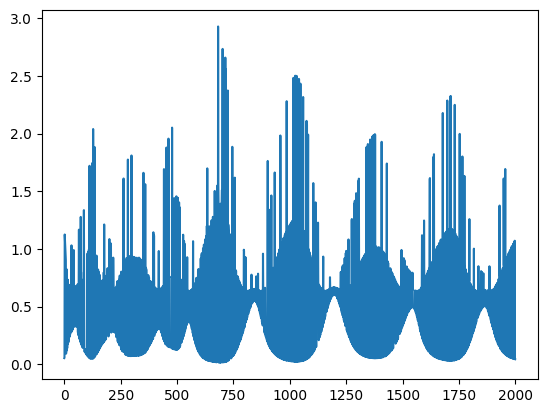

In [7]:
### plot training loss
%matplotlib inline
plt.plot(loss_list)
plt.show()

In [8]:
### evaluate on test data
v_list, facts = solver.predict(pos_test, neg_test, clauses, Ws)
mse = compute_mse(pos_test, neg_test, v_list, facts)
auc = compute_auc(pos_test, neg_test, v_list, facts)

print('====== TEST SCORE =======')
print('Mean-squared test error: ', mse)
print('AUC: ', auc)

Enumerating facts...
Building tensors...
====== TEST SCORE =======
Mean-squared test error:  0.16329764301329444
AUC:  0.6607142857142857


In [9]:
import json
import os
from datetime import datetime

def _fmt(v):
    if isinstance(v, float):
        return str(v).replace('.', 'p')
    return str(v)

results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
gen_mode = locals().get('gen_mode', 'beam')
name_parts = [
    problem,
    f'mode-{gen_mode}',
    f'Nmax-{_fmt(N_max)}',
    f'Tbeam-{_fmt(T_beam)}',
    f'Nbeam-{_fmt(N_beam)}',
    f'epoch-{_fmt(epoch)}',
    f'lr-{_fmt(lr)}',
    f'wd-{_fmt(0.0)}',
    f'm-{_fmt(m)}',
    f'T-{_fmt(T)}',
    ts,
]
out_name = '_'.join(name_parts) + '.json'
out_path = os.path.join(results_dir, out_name)

payload = {
    'problem': problem,
    'mode': gen_mode,
    'hyperparams': {
        'N_max': N_max,
        'T_beam': T_beam,
        'N_beam': N_beam,
        'epoch': epoch,
        'lr': lr,
        'wd': 0.0,
        'm': m,
        'T': T,
    },
    'metrics': {
        'mse': mse,
        'auc': auc,
    },
    'learned_rules': [str(c) for c in clauses],
}

with open(out_path, 'w') as f:
    json.dump(payload, f, indent=2)

print('Saved results to', out_path)


Saved results to results/windy_lava_mode-beam_Nmax-50_Tbeam-5_Nbeam-10_epoch-2000_lr-0p01_wd-0p0_m-2_T-4_20251224_123801.json


Enumerating facts...
Building tensors...


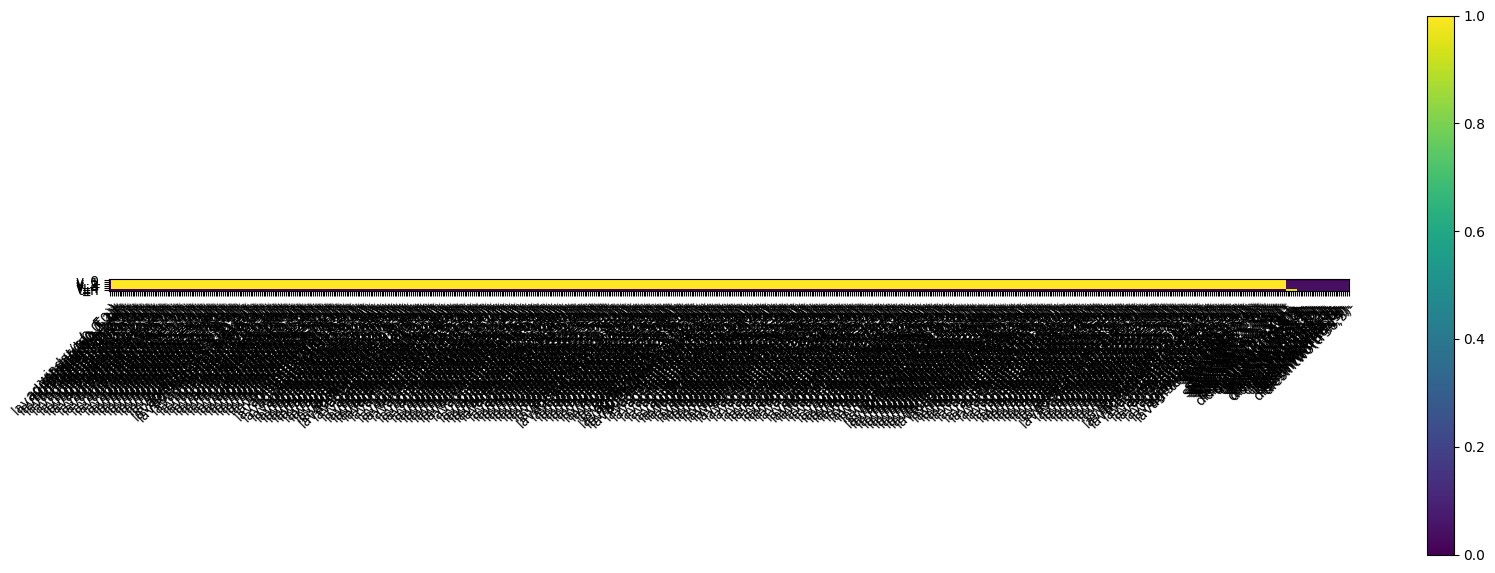

In [10]:
# Visualize v_0, v_1, ..., v_n after learning

v_list, facts = solver.get_valuation_memory(pos_test, neg_test, clauses, Ws)
ilp_test = ILPProblem(pos_test, neg_test, bk, lang, name=problem)
vis = Visualize(ilp_test, name=problem, facts=facts)
vis.plot_valuation_memory(v_list)